looking at change in entries at a particular timestampe across 8/31 --> 9/1/2021 by turnstile

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import contextily as cx

In [2]:
engine= create_engine('sqlite:///mta_data.db')
engine.table_names()

['mta_data']

In [3]:
df=pd.read_sql('SELECT * FROM mta_data where DATE in ("10/24/2021","10/25/2021","10/26/2021");',engine)

In [5]:
df.shape #(90140, 11)

(90140, 11)

In [4]:
#look at just two days 
df_20211026 = df

#clean data
df_20211026.columns = [column.strip() for column in df_20211026.columns]
df_20211026["DATE_TIME"] = pd.to_datetime(df_20211026.DATE + " " + df_20211026.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [6]:
#check for any duplicate rows
(df_20211026
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
41368,N409,R268,00-00-01,METROPOLITAN AV,2021-10-24 05:00:00,2
0,A002,R051,02-00-00,59 ST,2021-10-24 00:00:00,1
60089,R138,R293,00-05-01,34 ST-PENN STA,2021-10-25 22:00:00,1
60097,R138,R293,00-06-00,34 ST-PENN STA,2021-10-24 06:00:00,1
60096,R138,R293,00-06-00,34 ST-PENN STA,2021-10-24 02:00:00,1


In [7]:
#remove duplicate rows
df_20211026.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df_20211026.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)    
df_20211026.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
90139,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,10/26/2021,21:00:00,REGULAR,5554,662,2021-10-26 21:00:00
90138,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,10/26/2021,17:00:00,REGULAR,5554,661,2021-10-26 17:00:00
90137,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,10/26/2021,13:00:00,REGULAR,5554,660,2021-10-26 13:00:00
90136,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,10/26/2021,09:00:00,REGULAR,5554,660,2021-10-26 09:00:00
90135,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,10/26/2021,05:00:00,REGULAR,5554,659,2021-10-26 05:00:00


In [8]:
turnstiles_daily = (df_20211026
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .agg({"ENTRIES":"first","EXITS":"first"})
)

In [11]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,10/24/2021,7656669,2623008
1,A002,R051,02-00-00,59 ST,10/25/2021,7657024,2623408
2,A002,R051,02-00-00,59 ST,10/26/2021,7657337,2623819
3,A002,R051,02-00-01,59 ST,10/24/2021,6768844,1549657
4,A002,R051,02-00-01,59 ST,10/25/2021,6769246,1549935


In [9]:
#what is the total entries/exits for a timestamp at a turnstile
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE","ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))
turnstiles_daily.head()
                                            

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_1004/1190403995.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,10/24/2021,7656669,2623008,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,10/25/2021,7657024,2623408,10/24/2021,7656669.0,2623008.0
2,A002,R051,02-00-00,59 ST,10/26/2021,7657337,2623819,10/25/2021,7657024.0,2623408.0
3,A002,R051,02-00-01,59 ST,10/24/2021,6768844,1549657,NaN,NaN,NaN
4,A002,R051,02-00-01,59 ST,10/25/2021,6769246,1549935,10/24/2021,6768844.0,1549657.0


In [10]:
# Drop the rows for the earliest date_time stamp in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,10/25/2021,7657024,2623408,10/24/2021,7656669.0,2623008.0
2,A002,R051,02-00-00,59 ST,10/26/2021,7657337,2623819,10/25/2021,7657024.0,2623408.0
4,A002,R051,02-00-01,59 ST,10/25/2021,6769246,1549935,10/24/2021,6768844.0,1549657.0
5,A002,R051,02-00-01,59 ST,10/26/2021,6769605,1550238,10/25/2021,6769246.0,1549935.0
7,A002,R051,02-03-00,59 ST,10/25/2021,1463157,5535934,10/24/2021,1462884.0,5534697.0


In [11]:
#calculate counts for entries

def get_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

In [12]:
#calculate counts for exits

def get_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_counts, axis=1, max_counter=10000)

In [13]:
#check the calculation 
mask = ((turnstiles_daily["C/A"] == "A011") & 
(turnstiles_daily["UNIT"] == "R080") & 
(turnstiles_daily["SCP"] == "01-03-00") & 
(turnstiles_daily["STATION"] == "57 ST-7 AV") )

turnstiles_daily[mask].head()


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
118,A011,R080,01-03-00,57 ST-7 AV,10/25/2021,885559940,489428739,10/24/2021,885560305.0,489429961.0,365.0,1222.0
119,A011,R080,01-03-00,57 ST-7 AV,10/26/2021,885559619,489427513,10/25/2021,885559940.0,489428739.0,321.0,1226.0


In [14]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()
station_daily["DAILY_TOTALS"]= station_daily["DAILY_ENTRIES"]+station_daily["DAILY_EXITS"]
station_daily.head()

/var/folders/s5/kqm0k4xj165fxvtjxq0njrq00000gn/T/ipykernel_1004/546621034.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  station_daily = turnstiles_daily.groupby(["STATION", "DATE"])['DAILY_ENTRIES','DAILY_EXITS'].sum().reset_index()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
0,1 AV,10/25/2021,9794.0,16778.0,26572.0
1,1 AV,10/26/2021,9157.0,16272.0,25429.0
2,103 ST,10/25/2021,15307.0,15532.0,30839.0
3,103 ST,10/26/2021,13796.0,14652.0,28448.0
4,103 ST-CORONA,10/25/2021,12450.0,13341.0,25791.0


In [15]:
prcp_df = pd.read_csv('daily_prcp_2021.csv')
prcp_df =  prcp_df[['date','prcp']]

In [16]:
prcp_df

,date,prcp
0,01/01/2021,16.8
1,01/02/2021,1.5
2,01/03/2021,4.1
3,01/04/2021,0.3
4,01/05/2021,0.0
...,...,...
360,12/27/2021,2.0
361,12/28/2021,1.3
362,12/29/2021,4.1
363,12/30/2021,1.3


In [17]:
#merge precipitation data with turnstile data
turnstiles_daily_prcp = pd.merge(station_daily
                            , prcp_df
                            , how='left' 
                            , left_on=['DATE']
                            , right_on=['date']
)

In [18]:
turnstiles_daily_prcp

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,date,prcp
0,1 AV,10/25/2021,9794.0,16778.0,26572.0,10/25/2021,10.2
1,1 AV,10/26/2021,9157.0,16272.0,25429.0,10/26/2021,63.0
2,103 ST,10/25/2021,15307.0,15532.0,30839.0,10/25/2021,10.2
3,103 ST,10/26/2021,13796.0,14652.0,28448.0,10/26/2021,63.0
4,103 ST-CORONA,10/25/2021,12450.0,13341.0,25791.0,10/25/2021,10.2
...,...,...,...,...,...,...,...
751,WTC-CORTLANDT,10/26/2021,3251.0,4393.0,7644.0,10/26/2021,63.0
752,YORK ST,10/25/2021,4142.0,4622.0,8764.0,10/25/2021,10.2
753,YORK ST,10/26/2021,3638.0,4372.0,8010.0,10/26/2021,63.0
754,ZEREGA AV,10/25/2021,1460.0,1730.0,3190.0,10/25/2021,10.2


In [19]:
#pull out only 10/25 data 
df_1025 =turnstiles_daily_prcp[(turnstiles_daily_prcp.DATE == '10/25/2021')][
                            ["STATION","DATE","DAILY_ENTRIES","DAILY_EXITS","DAILY_TOTALS","prcp"]]
df_1025.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,prcp
0,1 AV,10/25/2021,9794.0,16778.0,26572.0,10.2
2,103 ST,10/25/2021,15307.0,15532.0,30839.0,10.2
4,103 ST-CORONA,10/25/2021,12450.0,13341.0,25791.0,10.2
6,104 ST,10/25/2021,2654.0,1530.0,4184.0,10.2
8,110 ST,10/25/2021,5755.0,7079.0,12834.0,10.2


In [20]:
#pull out only 10/26 data
df_1026 =turnstiles_daily_prcp[(turnstiles_daily_prcp.DATE == '10/26/2021')][
                            ["STATION","DATE","DAILY_ENTRIES","DAILY_EXITS","DAILY_TOTALS","prcp"]]
df_1026.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,prcp
1,1 AV,10/26/2021,9157.0,16272.0,25429.0,63.0
3,103 ST,10/26/2021,13796.0,14652.0,28448.0,63.0
5,103 ST-CORONA,10/26/2021,11253.0,12436.0,23689.0,63.0
7,104 ST,10/26/2021,2441.0,1536.0,3977.0,63.0
9,110 ST,10/26/2021,4894.0,6627.0,11521.0,63.0


In [21]:
#merge the two date's data frames
df_merged = pd.merge(df_1025
                            , df_1026
                            , how='inner' 
                            , left_on=["STATION"]
                            , right_on=["STATION"]
)[["STATION","DATE_x","prcp_x","DAILY_ENTRIES_x","DAILY_EXITS_x","DAILY_TOTALS_x","DATE_y","prcp_y","DAILY_ENTRIES_y","DAILY_EXITS_y","DAILY_TOTALS_y"]]

df_merged.head()

,STATION,DATE_x,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,DATE_y,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y
0,1 AV,10/25/2021,10.2,9794.0,16778.0,26572.0,10/26/2021,63.0,9157.0,16272.0,25429.0
1,103 ST,10/25/2021,10.2,15307.0,15532.0,30839.0,10/26/2021,63.0,13796.0,14652.0,28448.0
2,103 ST-CORONA,10/25/2021,10.2,12450.0,13341.0,25791.0,10/26/2021,63.0,11253.0,12436.0,23689.0
3,104 ST,10/25/2021,10.2,2654.0,1530.0,4184.0,10/26/2021,63.0,2441.0,1536.0,3977.0
4,110 ST,10/25/2021,10.2,5755.0,7079.0,12834.0,10/26/2021,63.0,4894.0,6627.0,11521.0


In [22]:
df_merged.describe()

,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y
count,3.780000e+02,378.000000,378.000000,378.00000,378.0,378.000000,378.000000,378.000000
mean,1.020000e+01,6599.230159,7360.452381,13959.68254,63.0,5928.809524,6753.248677,12682.058201
std,6.759103e-14,7616.277403,9868.383955,17363.24548,0.0,6964.475271,9096.652468,15956.524863
min,1.020000e+01,130.000000,0.000000,224.00000,63.0,0.000000,0.000000,182.000000
25%,1.020000e+01,2356.750000,2056.500000,4498.50000,63.0,2087.000000,1918.000000,4056.750000
50%,1.020000e+01,4104.500000,4354.500000,8481.50000,63.0,3645.500000,3798.000000,7318.500000
75%,1.020000e+01,7296.750000,7986.250000,15426.50000,63.0,6551.500000,7312.750000,14503.000000
max,1.020000e+01,59093.000000,77850.000000,136943.00000,63.0,52520.000000,70302.000000,122822.000000


In [23]:
#calculate the change in entries/exits at a particular turnstile over the two days

df_merged["TOTAL_p_delta"]= df_merged.DAILY_TOTALS_y/df_merged.DAILY_TOTALS_x-1 
df_merged["TOTAL_delta"]= df_merged.DAILY_TOTALS_y-df_merged.DAILY_TOTALS_x 

df_merged

,STATION,DATE_x,prcp_x,DAILY_ENTRIES_x,DAILY_EXITS_x,DAILY_TOTALS_x,DATE_y,prcp_y,DAILY_ENTRIES_y,DAILY_EXITS_y,DAILY_TOTALS_y,TOTAL_p_delta,TOTAL_delta
0,1 AV,10/25/2021,10.2,9794.0,16778.0,26572.0,10/26/2021,63.0,9157.0,16272.0,25429.0,-0.043015,-1143.0
1,103 ST,10/25/2021,10.2,15307.0,15532.0,30839.0,10/26/2021,63.0,13796.0,14652.0,28448.0,-0.077532,-2391.0
2,103 ST-CORONA,10/25/2021,10.2,12450.0,13341.0,25791.0,10/26/2021,63.0,11253.0,12436.0,23689.0,-0.081501,-2102.0
3,104 ST,10/25/2021,10.2,2654.0,1530.0,4184.0,10/26/2021,63.0,2441.0,1536.0,3977.0,-0.049474,-207.0
4,110 ST,10/25/2021,10.2,5755.0,7079.0,12834.0,10/26/2021,63.0,4894.0,6627.0,11521.0,-0.102306,-1313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,WOODLAWN,10/25/2021,10.2,3767.0,1416.0,5183.0,10/26/2021,63.0,3137.0,1320.0,4457.0,-0.140073,-726.0
374,WORLD TRADE CTR,10/25/2021,10.2,5382.0,6652.0,12034.0,10/26/2021,63.0,4513.0,5611.0,10124.0,-0.158717,-1910.0
375,WTC-CORTLANDT,10/25/2021,10.2,3785.0,4816.0,8601.0,10/26/2021,63.0,3251.0,4393.0,7644.0,-0.111266,-957.0
376,YORK ST,10/25/2021,10.2,4142.0,4622.0,8764.0,10/26/2021,63.0,3638.0,4372.0,8010.0,-0.086034,-754.0


In [24]:
#top increases 
top_increases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_delta",ascending= False)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_delta"]]

top_increases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
72,47-50 STS ROCK,10/25/2021,10/26/2021,45286.0,46271.0,985.0
91,66 ST-LINCOLN,10/25/2021,10/26/2021,21228.0,21913.0,685.0
55,3 AV-149 ST,10/25/2021,10/26/2021,18142.0,18614.0,472.0
98,72 ST-2 AVE,10/25/2021,10/26/2021,30922.0,31353.0,431.0
199,DEKALB AV,10/25/2021,10/26/2021,26144.0,26516.0,372.0
75,5 AV/53 ST,10/25/2021,10/26/2021,20049.0,20399.0,350.0
79,51 ST,10/25/2021,10/26/2021,15015.0,15360.0,345.0
77,5 AVE,10/25/2021,10/26/2021,9130.0,9296.0,166.0
206,EAST 105 ST,10/25/2021,10/26/2021,3748.0,3892.0,144.0
356,UNION ST,10/25/2021,10/26/2021,6286.0,6405.0,119.0


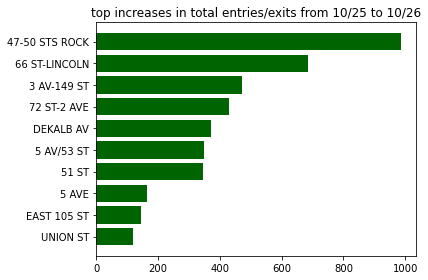

In [45]:

y = top_increases.TOTAL_delta
x = top_increases.STATION

plt.figure(facecolor='white')

plt.barh (x,y,color='#006400')
plt.gca().invert_yaxis()
plt.title ("top increases in total entries/exits from 10/25 to 10/26")
plt.tight_layout()
plt.savefig('top_increases_20211026.png',bbox_inches='tight')

In [26]:
#top % increases 
top_p_increases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_p_delta",ascending= False)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_p_delta"]]

top_p_increases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_p_delta
206,EAST 105 ST,10/25/2021,10/26/2021,3748.0,3892.0,0.038420
299,NEWARK C,10/25/2021,10/26/2021,2458.0,2551.0,0.037836
91,66 ST-LINCOLN,10/25/2021,10/26/2021,21228.0,21913.0,0.032269
55,3 AV-149 ST,10/25/2021,10/26/2021,18142.0,18614.0,0.026017
79,51 ST,10/25/2021,10/26/2021,15015.0,15360.0,0.022977
72,47-50 STS ROCK,10/25/2021,10/26/2021,45286.0,46271.0,0.021751
126,ATLANTIC AV,10/25/2021,10/26/2021,1517.0,1549.0,0.021094
356,UNION ST,10/25/2021,10/26/2021,6286.0,6405.0,0.018931
77,5 AVE,10/25/2021,10/26/2021,9130.0,9296.0,0.018182
75,5 AV/53 ST,10/25/2021,10/26/2021,20049.0,20399.0,0.017457


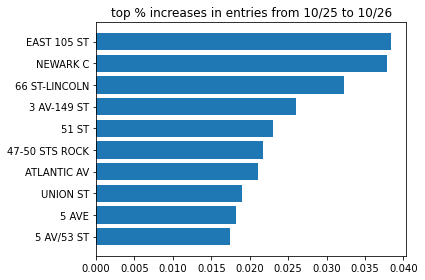

In [27]:

y = top_p_increases.TOTAL_p_delta
x = top_p_increases.STATION

plt.figure(facecolor='white')

plt.barh (x,y)
plt.gca().invert_yaxis()
plt.title ("top % increases in entries from 10/25 to 10/26")
plt.tight_layout()
plt.savefig('top_p_increases.png')

In [28]:
#top decreases 
top_decreases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_delta",ascending= True)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_delta"]]

top_decreases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
61,34 ST-PENN STA,10/25/2021,10/26/2021,136943.0,122822.0,-14121.0
86,59 ST COLUMBUS,10/25/2021,10/26/2021,61459.0,49467.0,-11992.0
314,PATH NEW WTC,10/25/2021,10/26/2021,47435.0,36429.0,-11006.0
9,125 ST,10/25/2021,10/26/2021,80306.0,70992.0,-9314.0
226,FULTON ST,10/25/2021,10/26/2021,77821.0,69012.0,-8809.0
59,34 ST-HERALD SQ,10/25/2021,10/26/2021,96594.0,87864.0,-8730.0
14,14 ST-UNION SQ,10/25/2021,10/26/2021,88234.0,79637.0,-8597.0
258,JOURNAL SQUARE,10/25/2021,10/26/2021,27160.0,20152.0,-7008.0
217,FLUSHING-MAIN,10/25/2021,10/26/2021,64877.0,57961.0,-6916.0
173,CANAL ST,10/25/2021,10/26/2021,54081.0,47303.0,-6778.0


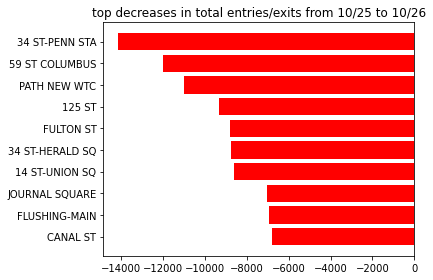

In [46]:
#top decreases
y = top_decreases.TOTAL_delta.sort_values(ascending = True)
x = top_decreases.STATION

plt.figure(facecolor='white')

plt.barh (x,y,color='r')
plt.gca().invert_yaxis()
plt.title ("top decreases in total entries/exits from 10/25 to 10/26") 
plt.tight_layout()
plt.savefig('top_decreases_20211026.png')

In [31]:
#top % decreases 
top_p_decreases = (df_merged
                    .replace([np.inf, -np.inf], np.nan) #replace infinities with NA's and drop NA's
                    .dropna(axis=0)
                    .sort_values("TOTAL_p_delta",ascending= True)
                    .head(10)
                    )[["STATION","DATE_x","DATE_y","DAILY_TOTALS_x","DAILY_TOTALS_y","TOTAL_p_delta"]]

top_p_decreases


,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_p_delta
300,NEWARK HM HE,10/25/2021,10/26/2021,13085.0,7558.0,-0.422392
301,NEWARK HW BMEBE,10/25/2021,10/26/2021,5703.0,3558.0,-0.376118
239,HARRISON,10/25/2021,10/26/2021,8499.0,5953.0,-0.299565
353,TOMPKINSVILLE,10/25/2021,10/26/2021,495.0,348.0,-0.296970
17,14TH STREET,10/25/2021,10/26/2021,9166.0,6497.0,-0.291185
316,PAVONIA/NEWPORT,10/25/2021,10/26/2021,14269.0,10340.0,-0.275352
329,RIT-ROOSEVELT,10/25/2021,10/26/2021,2072.0,1511.0,-0.270753
258,JOURNAL SQUARE,10/25/2021,10/26/2021,27160.0,20152.0,-0.258027
279,METS-WILLETS PT,10/25/2021,10/26/2021,3330.0,2483.0,-0.254354
328,RIT-MANHATTAN,10/25/2021,10/26/2021,3281.0,2461.0,-0.249924


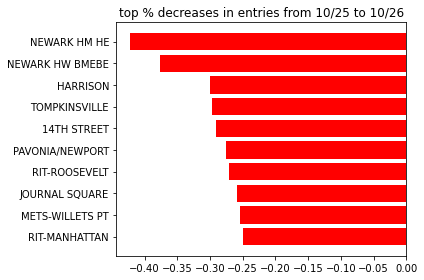

In [50]:
y = top_p_decreases.TOTAL_p_delta.sort_values(ascending = True)
x = top_p_decreases.STATION

plt.figure(facecolor='white')

plt.barh (x,y,color='r')
plt.gca().invert_yaxis()
plt.title ("top % decreases in entries from 10/25 to 10/26")
plt.tight_layout()
plt.savefig('top_p_decreases-20221026.png')

In [33]:
#Mapping 
locations = pd.read_csv('nyc_transit_location_data.csv')
locations = locations[["Station Name","Station Latitude","Station Longitude"]]

#append manually missing station
line =pd.DataFrame({"Station Name":"Journal Square",
"Station Latitude" : 40.73323535357566,
"Station Longitude":-74.0626471842798,
"geometry":"POINT (40.73324 -74.06265)"},index=[1868])
locations= locations.append(line)

geometry = [Point(xy) for xy in zip(locations["Station Latitude"], locations["Station Longitude"])]
gdf = GeoDataFrame(locations, geometry=geometry)
gdf.set_crs(epsg=4326, inplace = True)


,Station Name,Station Latitude,Station Longitude,geometry
0,103rd St,40.796092,-73.961454,POINT (40.79609 -73.96145)
1,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
2,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
3,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
4,103rd St,40.799446,-73.968379,POINT (40.79945 -73.96838)
...,...,...,...,...
1864,Yankee Stadium-161st St,40.827994,-73.925831,POINT (40.82799 -73.92583)
1865,York St,40.699743,-73.986885,POINT (40.69974 -73.98689)
1866,Zerega Av,40.836488,-73.847036,POINT (40.83649 -73.84704)
1867,Zerega Av,40.836488,-73.847036,POINT (40.83649 -73.84704)


In [34]:
#only extract rows we're interested in
gdf_subset= gdf.iloc[[406,567,1841,52,1219,384,146,1868,1163,951],:].append( #top decreases
 gdf.iloc[[463,600,108,622,1071,582,509,572,1106,1755],:]).reset_index()

#merge geopanda with movement data
movement= top_decreases.append(top_increases).reset_index()
merged_gdf = pd.merge(gdf_subset,movement,left_index=True, right_index=True)
merged_gdf


,index_x,Station Name,Station Latitude,Station Longitude,geometry,index_y,STATION,DATE_x,DATE_y,DAILY_TOTALS_x,DAILY_TOTALS_y,TOTAL_delta
0,406,34th St,40.750373,-73.991057,POINT (40.75037 -73.99106),61,34 ST-PENN STA,10/25/2021,10/26/2021,136943.0,122822.0,-14121.0
1,567,59th St-Columbus Circle,40.768247,-73.981929,POINT (40.76825 -73.98193),86,59 ST COLUMBUS,10/25/2021,10/26/2021,61459.0,49467.0,-11992.0
2,1841,World Trade Center,40.712582,-74.009781,POINT (40.71258 -74.00978),314,PATH NEW WTC,10/25/2021,10/26/2021,47435.0,36429.0,-11006.0
3,52,125th St,40.811109,-73.952343,POINT (40.81111 -73.95234),9,125 ST,10/25/2021,10/26/2021,80306.0,70992.0,-9314.0
4,1219,Fulton St,40.709416,-74.006571,POINT (40.70942 -74.00657),226,FULTON ST,10/25/2021,10/26/2021,77821.0,69012.0,-8809.0
5,384,34th St,40.749719,-73.987823,POINT (40.74972 -73.98782),59,34 ST-HERALD SQ,10/25/2021,10/26/2021,96594.0,87864.0,-8730.0
6,146,14th St-Union Square,40.734673,-73.989951,POINT (40.73467 -73.98995),14,14 ST-UNION SQ,10/25/2021,10/26/2021,88234.0,79637.0,-8597.0
7,1868,Journal Square,40.733235,-74.062647,POINT (40.73324 -74.06265),258,JOURNAL SQUARE,10/25/2021,10/26/2021,27160.0,20152.0,-7008.0
8,1163,Flushing-Main St,40.759600,-73.830030,POINT (40.75960 -73.83003),217,FLUSHING-MAIN,10/25/2021,10/26/2021,64877.0,57961.0,-6916.0
9,951,Canal St,40.720824,-74.005229,POINT (40.72082 -74.00523),173,CANAL ST,10/25/2021,10/26/2021,54081.0,47303.0,-6778.0


In [35]:
#read in geomaps
flood_df = gpd.read_file('NYC Stormwater Flood Map - Extreme Flood.gdb').to_crs(epsg=4326)

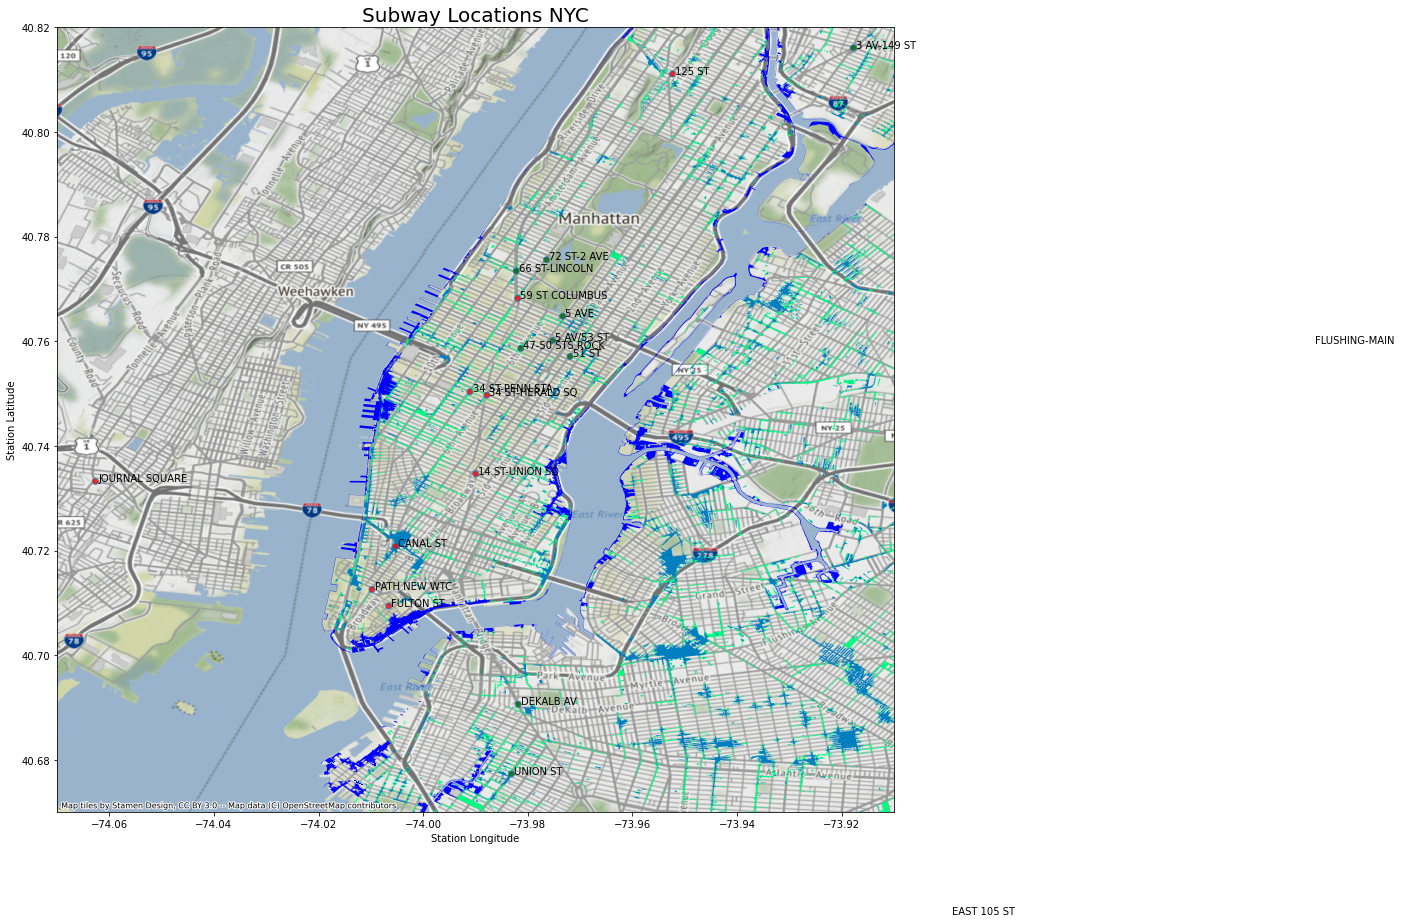

<Figure size 432x288 with 0 Axes>

In [56]:
#Flood Mapping
ax = flood_df.plot(column='Flooding_Category',figsize=(15, 15),cmap="winter_r")
minx, miny, maxx, maxy = flood_df.total_bounds
ax.set_xlim(-74.07, -73.91)
ax.set_ylim(40.67, 40.82)
cx.add_basemap(ax, crs='EPSG:4326')

#customize color of stations & plot
value=(merged_gdf['TOTAL_delta']<0)
merged_gdf['color']= np.where( value==True , "r", "#006400")

sns.regplot(data=merged_gdf, x="Station Longitude", y="Station Latitude",
          fit_reg=False, marker="o", scatter_kws={'facecolor':merged_gdf['color']})
 
# add annotations one by one with a loop
for line in range(0,merged_gdf.shape[0]):
     plt.text(merged_gdf["Station Longitude"][line]+0.0005, merged_gdf["Station Latitude"][line], merged_gdf["STATION"][line],
     horizontalalignment='left', size='medium', color='black', weight='normal')

plt.title("Subway Locations NYC", size=20)
plt.show()
plt.savefig('map_20211026.png')